Imports

In [5]:
import sys
import os
import glob
import random
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

Read Files

In [6]:
files = []
path = 'archive-2/lgg-mri-segmentation/kaggle_3m/'

# the ground truth are files marked with 'mask'
mask_files = glob.glob(path + '*/*_mask*')
data = pd.read_csv(path + "data.csv")
for i in mask_files:
    # for the truthful mask files, retrieve the blank image
    files.append(i.replace('_mask',''))

Preprocess Data

In [7]:
df = pd.DataFrame()
df['img']= files
df['mask']= mask_files

# label the classification from the masked files
def labels(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0:
        return 1
    else: return 0

df['label'] = df['mask'].apply(labels)
print("Number of non tumours: " + str(df.label.value_counts()[0]))
print("Number of tumours: " + str(df.label.value_counts()[1]))


Number of non tumours: 2556
Number of tumours: 1373


Since the number of classifications are somewhat evenly distributed, we can directly use the whole dataset.

Group Dataset By Patients

In [8]:
# group by patients

def path(x):
  y = x.split("/")[-1]
  z = y.split(".")[0]
  z1 = z.split("_")
  return "_".join(z1[:-2])

df['Patient'] = df.img.apply(path)
k = df.groupby(df.Patient)
l = k.size()
rows, cols = 5, 5
l = k.get_group('TCGA_CS_4941')


Load an image and it's corresponding mask for one patient

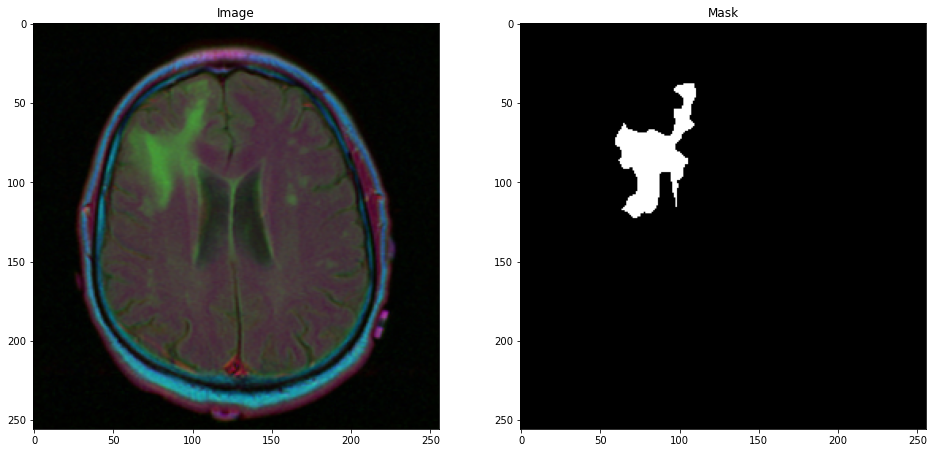

(256, 256, 3)


In [9]:
fig = plt.figure(figsize=(16, 16))

plt.subplot(121)
img = cv2.imread(l['img'].iloc[0], cv2.IMREAD_UNCHANGED)
plt.imshow(img)
plt.title("Image")

plt.subplot(122)
msk_path = l['mask'].iloc[0]
msk = cv2.imread(msk_path)
plt.imshow(msk)
plt.title("Mask")

plt.show()

print(img.shape)


In [11]:
df

,img,mask,label,Patient
0,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,0,TCGA_CS_6667
1,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,0,TCGA_CS_6667
2,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,0,TCGA_CS_6667
3,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,0,TCGA_CS_6667
4,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,0,TCGA_CS_6667
...,...,...,...,...
3924,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,0,TCGA_FG_A60K
3925,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,0,TCGA_FG_A60K
3926,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,0,TCGA_FG_A60K
3927,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m/TCGA_...,0,TCGA_FG_A60K


In [57]:
# downsize the input images

import os.path
import cv2
import numpy as np

def load_data():
    images = []
    masks = []

    # image size
    size = 32, 32

    # Iterate through each image in each subfolder
    for index in range(len(df.index)):
        img = df['img'][index]
        temp_img = cv2.imread(img, cv2.IMREAD_UNCHANGED)

        mask = df['mask'][index]
        temp_mask = cv2.imread(mask)

        if temp_img is None:
            continue

        # Resize the images
        temp_img = cv2.resize(temp_img, size)
        images.append(temp_img)

        temp_mask = cv2.resize(temp_mask, size)
        masks.append(temp_mask)

    # Convert to a numpy array
    images = np.array(images)
    masks = np.array(masks)

    # Normalize the images
    images = images.astype('float32')/255.0
    # masks = masks.astype('float32')/255.0

    return images, masks

downsized_images, downsized_masks = load_data()


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import MeanIoU

# Define U-Net model architecture

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same',
        activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))

model.add(layers.Flatten())

model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(64, activation='sigmoid'))

model.add(layers.Dense(29, activation='softmax'))

model.summary()


: 

: 

In [ ]:
X_train, Y_train = load_data()  # function to load and preprocess dataset and mask


In [ ]:
model = unet(input_size=(256, 256, 1))
model.fit(X_train, Y_train, batch_size=16, epochs=50, validation_split=0.1)


In [ ]:
X_test = load_new_data()  # function to load and preprocess new brain images
Y_pred = model.predict(X_test)
